# Factory Lamination Data: Machine Learning
The Goal of this notebook is to analyze a dataset we got from the South Hadley Factory with many features, and our goal is to be able to predict the pass/fail column

In [146]:
# We need to gain access to some of Python's libraries
import os
import glob
import pandas as pd
import sklearn as sk
import sklearn.model_selection
import numpy as np
import sklearn_pandas
import functools
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
import statistics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt



# Here we will set our Data
1. Set the filepath to the location of your dataset

In [130]:
file_path = r"C:\Users\JCourtney\Desktop\Python Eink U\Machine Learning Exercise\PS50C lam for machine learning.xlsx"
rawDataFrame = pd.read_excel(file_path)






#Temporary
#copy = r"C:\Users\JCourtney\Desktop\Python Eink U\Machine Learning Exercise\PS50C lam for machine learning - Copy.xlsx"
#data = pd.read_excel(copy)

#data.head()


## Choosing Features
### It is being assumed that all data besides the target in the file will be a feature


In [112]:
#Type the name of the column that is your target data, and other data you may want to drop
targetName = "RA, fail/pass"
otherDrops = ["fail/pass percentage, %", "\nWater resistance pinched width,mean,  mm","RA quantity"]
#isolate target
target = rawDataFrame[targetName]
#Remove target from features set
otherDrops.append(targetName)
data = rawDataFrame.drop(columns=otherDrops)


In [127]:
# What I need to do here is create a function that will, for each column, go through and create categorical true/false data and/or fill in missing data points with the mean



#This function, when given the rawData, will return a dataframe with all of the same information but formatted into a usable manner
def process_data(frame):
    #First I am splitting up the numeric and string clumns
    sampleNumeric = frame._get_numeric_data()
    #print(sampleNumeric)
    sampleString = frame.select_dtypes(exclude="number")
   
    #Second I am going to impute the numerical columns, this will be enough editing for them
    my_imputer = SimpleImputer(strategy="median")
    if not sampleNumeric.empty:
        imputed_col_numbers = pd.DataFrame(my_imputer.fit_transform(sampleNumeric))
        imputed_col_numbers.columns = sampleNumeric.columns
    else:
        imputed_col_numbers = sampleNumeric
    
    

    #Third I am going to impute the categorical columns, which will need to be further edited
    cat_imputer = SimpleImputer(strategy="most_frequent")
    if not sampleString.empty:
        imputed_col_strings = pd.DataFrame(cat_imputer.fit_transform(sampleString.astype(str)))
        imputed_col_strings.columns = sampleString.columns
    else:
        imputed_col_strings = sampleString
    #print(imputed_col_strings)


    #Fourth I need to implement "One-Hot Encoding" which represents categorical data in numerics (or booleans but True == 1 False == 0) so the machine learning can understand
    #Creating empty df to add values to
    final_categorical = pd.DataFrame([])
    #Making a list of dataFrame columns
    columns = list(imputed_col_strings)

    for i in columns:
        categories = list(imputed_col_strings[i].value_counts().index.get_level_values(0))
        if len(categories) > 2:
            #Count is greater than two, I need to do one column for every category
            for cat in categories:
                partial_boolean = functools.partial(boolean, category = cat)
                one_hot = imputed_col_strings[i].apply(partial_boolean).rename(str(imputed_col_strings.columns[i]) + "%s" % cat)
                final_categorical = pd.concat([final_categorical, one_hot], axis=1, join="outer", ignore_index=False)
            #If the count equals 2, we can make a truth table to represent this data
        elif len(categories) == 2:
            partial_boolean_binary = functools.partial(boolean, category = categories[0])
            final_categorical = pd.concat([final_categorical,imputed_col_strings[i].apply(partial_boolean_binary)], axis=1, join="outer", ignore_index=False)
    #Finally here we will recombine the numerical and categorical data and return the finished product
    return (pd.concat([imputed_col_numbers,final_categorical], axis=1, join="outer", ignore_index=False))


def target_imputer(tar):
    tar_imputer = SimpleImputer(strategy="most_frequent")
    tar = tar.to_frame()
    imputed_target = pd.DataFrame(tar_imputer.fit_transform(tar))
    return pd.Series(np.ravel(imputed_target))


# Helper function to be applied to each column using the partial function object
def boolean(x, category):
    if x == category:
        return 1
    else:
        return 0


#We are going to apply this function to our data :)

data = process_data(data)
imputed_target_frame = target_imputer(target)

#print(imputed_target_frame)
partial_boolean_for_target = functools.partial(boolean, category = statistics.mode(imputed_target_frame))
imputed_encoded_target = imputed_target_frame.apply(partial_boolean_for_target)

            




0     1
1     0
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    0
20    1
21    1
22    1
23    0
24    0
25    0
26    1
27    0
28    1
dtype: int64


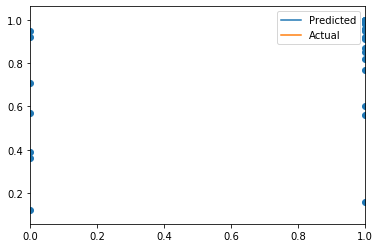

In [147]:

#In this block we set up all the variables we are going to need to create our models

#TODO: Need to make a function that given the name of the non-features column will make all the lists n stuff we need

#We are going to break a validation set off in order to train our model

X_train,X_valid,y_train,y_valid = sklearn.model_selection.train_test_split(data,imputed_encoded_target,train_size=.8,test_size=.2,random_state=0)

#I stole this from Kaggle
#def score_dataset(X_train, X_valid, y_train, y_valid):
    


model = RandomForestRegressor(n_estimators=100,random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_valid)
y_butnotwackyindex = y_valid.reset_index(drop = True)
print(y_butnotwackyindex)
pd.DataFrame([y_butnotwackyindex,preds],columns=["Actual","Predicted"]).plot(x = None, y=["Predicted","Actual"], kind = "line")
plt.scatter(y_butnotwackyindex, preds)



In [128]:
#Run this when u want to save data as a file
data.to_excel(r"C:\Users\JCourtney\Desktop\Python Eink U\Machine Learning Exercise\PS50C lam for machine learning - Copy2.xlsx")

In [111]:
# In this block we are going to attempt to create the models
from sklearn.ensemble import RandomForestRegressor

model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [113]:
#In this block we will train the models

from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    #print(X_t,y_t)
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 0
Model 2 MAE: 0
Model 3 MAE: 0
Model 4 MAE: 0
Model 5 MAE: 0
